# Assignment 2

# Question 1

In [1]:
# !wget https://warwick.ac.uk/fac/sci/dcs/teaching/material/cs909/patches_256.zip -O content/patches_256.zip
# !unzip content/patches_256.zip -d content/
# !wget https://warwick.ac.uk/fac/sci/dcs/teaching/material/cs909/protein_expression_data.csv -O content/protein_expression_data.csv


In [2]:
from pathlib import Path
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from skimage.color import rgb2hed, rgba2rgb
from skimage.io import imread
from tqdm import tqdm
import pickle

/tmp/ipykernel_7663/2002627561.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
CONTENT_FOLDER = Path("content/")
IMAGE_FOLDER = CONTENT_FOLDER / Path("patches_256/")
EXPRESSION_DATA_FILE = CONTENT_FOLDER / Path("protein_expression_data.csv")
CHECKPOINT_FOLDER = Path("checkpoints/")

df = pd.read_csv(EXPRESSION_DATA_FILE)

In [4]:
def make_checkpoint(obj, obj_name, rev_name, folder=CHECKPOINT_FOLDER, overwrite=False):
    if (folder / Path(obj_name) / Path(rev_name + ".pkl")).exists():
        if overwrite:
            print("Overwriting existing checkpoint.")
        else:
            print("Checkpoint already exists.")
            return
    folder = folder / Path(obj_name)
    folder.mkdir(parents=True, exist_ok=True)
    filepath = folder / Path(rev_name + ".pkl")
    with open(filepath, "wb") as f:
        print(f"Saving checkpoint to {filepath}")
        pickle.dump(obj, f)
        
def get_checkpoint(obj_name, rev_name, folder=CHECKPOINT_FOLDER):
    filepath = folder / Path(obj_name) / Path(rev_name + ".pkl")
    if not filepath.exists():
        print("Checkpoint not found.")
        return None
    with open(filepath, "rb") as f:
        print(f"Loading checkpoint from {filepath}")
        return pickle.load(f)
    

In [5]:

df['specimen_id']=df.VisSpot.apply(lambda x: x.split('-')[2]) #create specimen id field
df['image_id']=df.VisSpot.apply(lambda x: x.split('-')[2])+'_'+df.id #create image id field
df = df.set_index('image_id').sort_index()
protein_names = ['SMAa', 'CD11b',
       'CD44', 'CD31', 'CDK4', 'YKL40', 'CD11c', 'HIF1a', 'CD24', 'TMEM119',
       'OLIG2', 'GFAP', 'VISTA', 'IBA1', 'CD206', 'PTEN', 'NESTIN', 'TCIRG1',
       'CD74', 'MET', 'P2RY12', 'CD163', 'S100B', 'cMYC', 'pERK', 'EGFR',
       'SOX2', 'HLADR', 'PDGFRa', 'MCT4', 'DNA1', 'DNA3', 'MHCI', 'CD68',
       'CD14', 'KI67', 'CD16', 'SOX10']

### i

In [6]:
print("The number of examples for each specimen is as follows:")
print(df["specimen_id"].groupby(df["specimen_id"]).count())

The number of examples for each specimen is as follows:
specimen_id
A1    2894
B1    1145
C1    4129
D1    1753
Name: specimen_id, dtype: int64


### ii
The following is a collection of histograms representing the expression values of the proteins 'NESTIN', 'cMYC', and 'MET' for each specimen. The median for each is marked with a black dashed line.

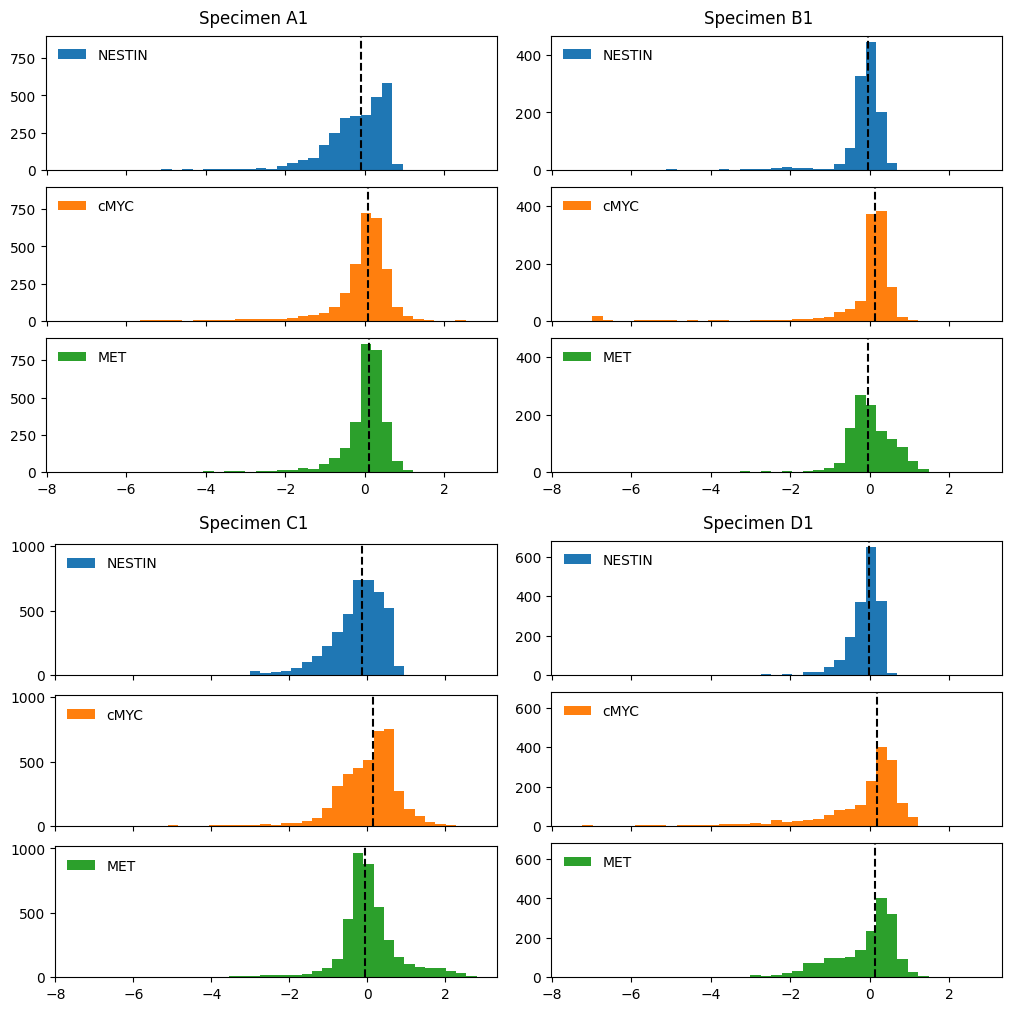

In [7]:
specimen_ids = df["specimen_id"].unique()
proteins_to_plot = ["NESTIN", "cMYC", "MET"]
num_bins = 30

# xbounds = (df[proteins_to_plot].min().min(), df[proteins_to_plot].max().max())
xbounds = (-7.5, 2.8)
bins = np.linspace(*xbounds, 40, endpoint=True)

fig = plt.figure(figsize=(10,10), layout="constrained")
subfigs = fig.subfigures(2,2)
for i, specimen_id in enumerate(specimen_ids):
    subfig = subfigs[i//2, i%2]
    axs = subfig.subplots(3, 1, sharex=True)
    df_specimen = df[df["specimen_id"]==specimen_id]
    for j, protein in enumerate(proteins_to_plot):
        axs[j].hist(df_specimen[protein], bins=bins, label=protein, color=f"C{j}")
        axs[j].legend(frameon=False, loc="upper left")
        axs[j].axvline(df_specimen[protein].median(), color="k", linestyle="--")
    subfig.suptitle(f"Specimen {specimen_id}")


for subfig in subfigs.flatten():
    lims = []
    for ax in subfig.get_axes():
        lims.append(ax.get_ylim())
    lims = list(zip(*lims))
    ybounds = (min(lims[0]), max(lims[1]))
    for ax in subfig.get_axes():
        ax.set_ylim(ybounds)
#

plt.show()

The distributions of the different proteins is broadly similar across the different specimens. The medians are all very close to 0 which is ideal as this suggests the data is already normalised. We will compare the distributions of each protein individually:
- NESTIN: B1 and D1 both have similar distributions with a smaller variance. A1 and C1 are similar with a larger variance and bigger left tail
- cMYC: B1 and D1 are again visually similar. A1 is more similar to these than to C1
- MET: All 4 distributions are quite varied.

### iii

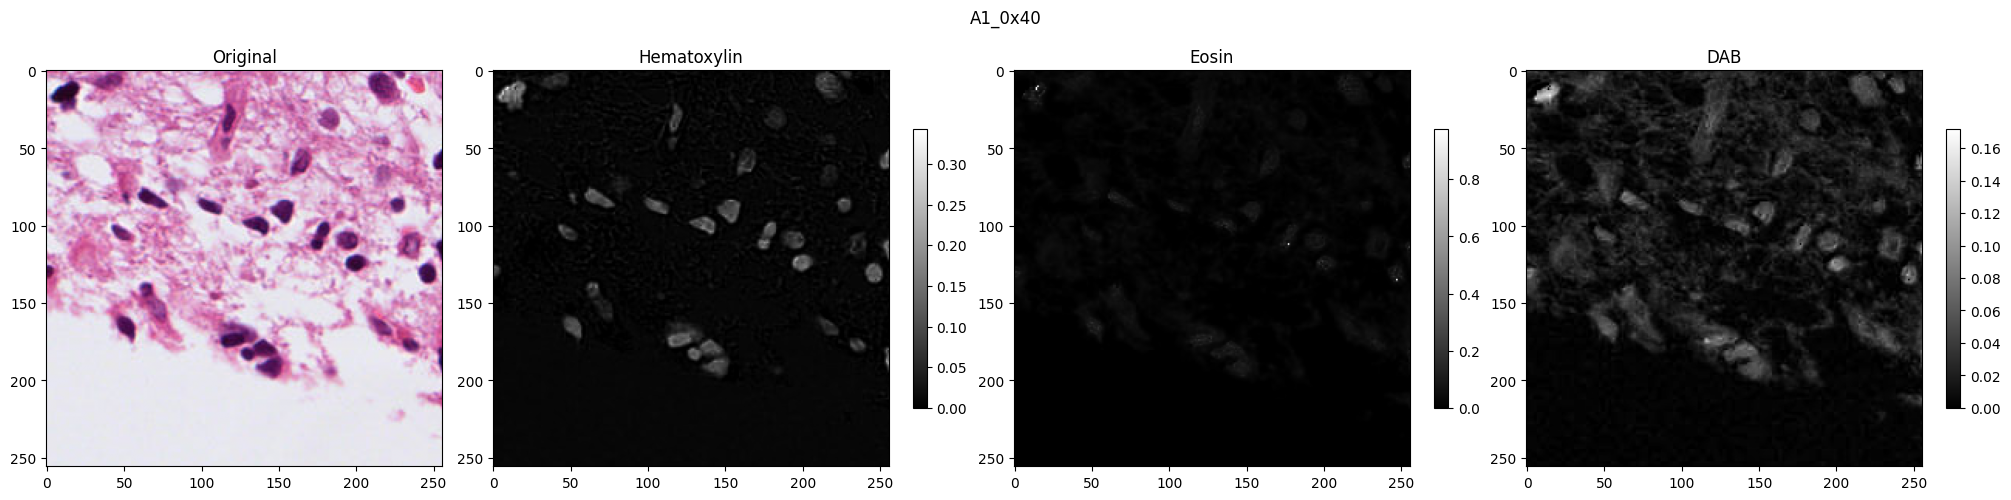

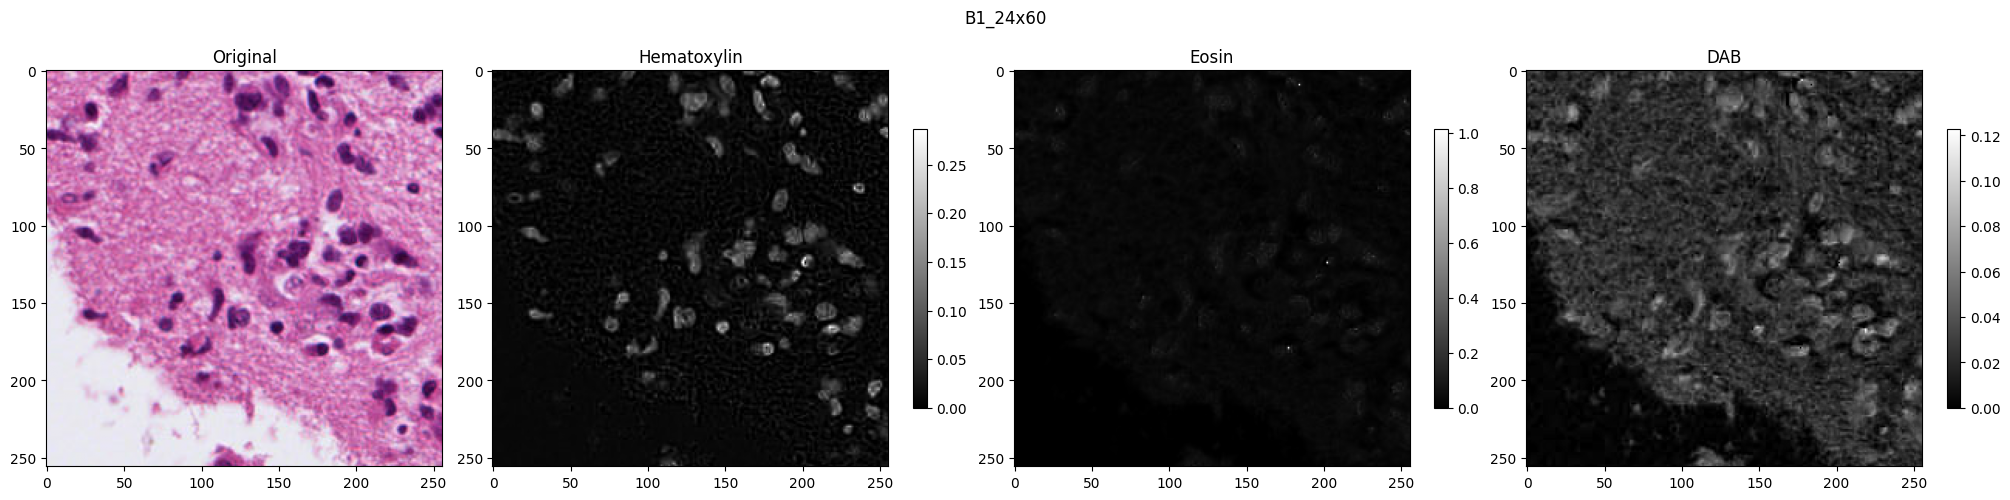

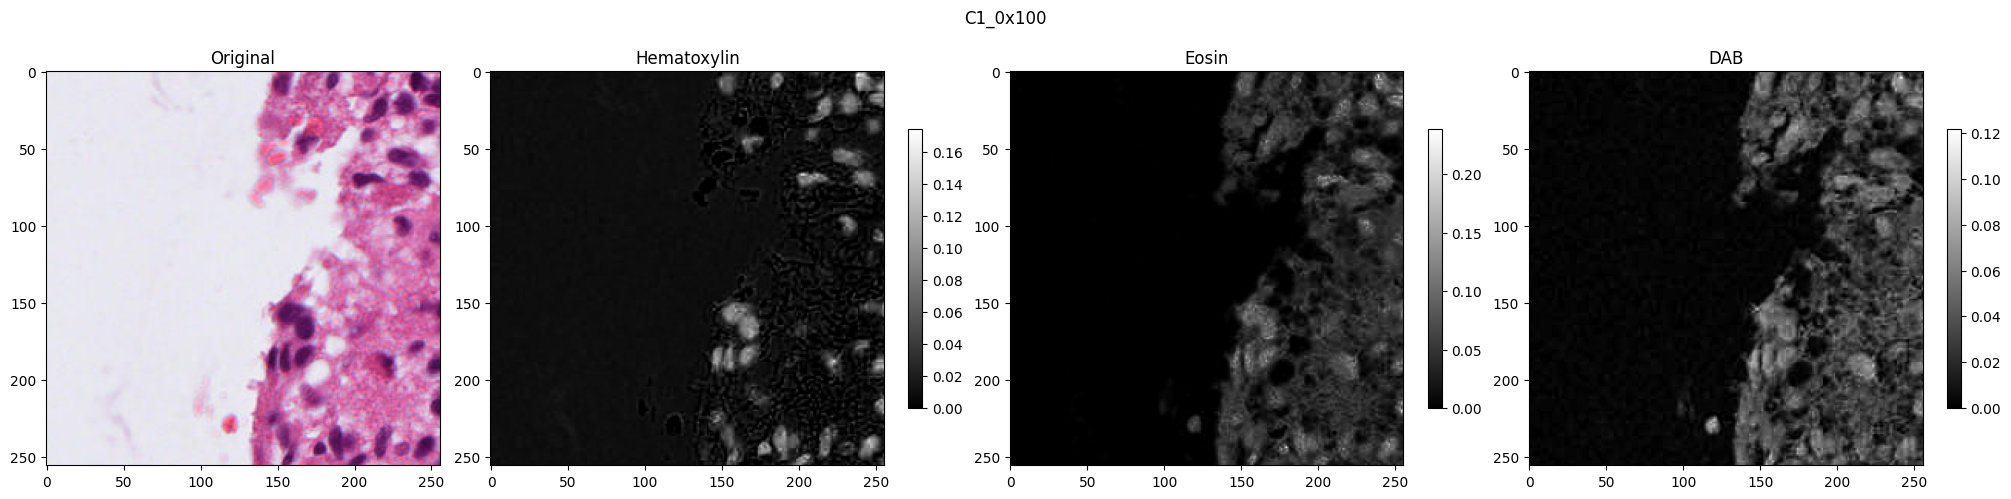

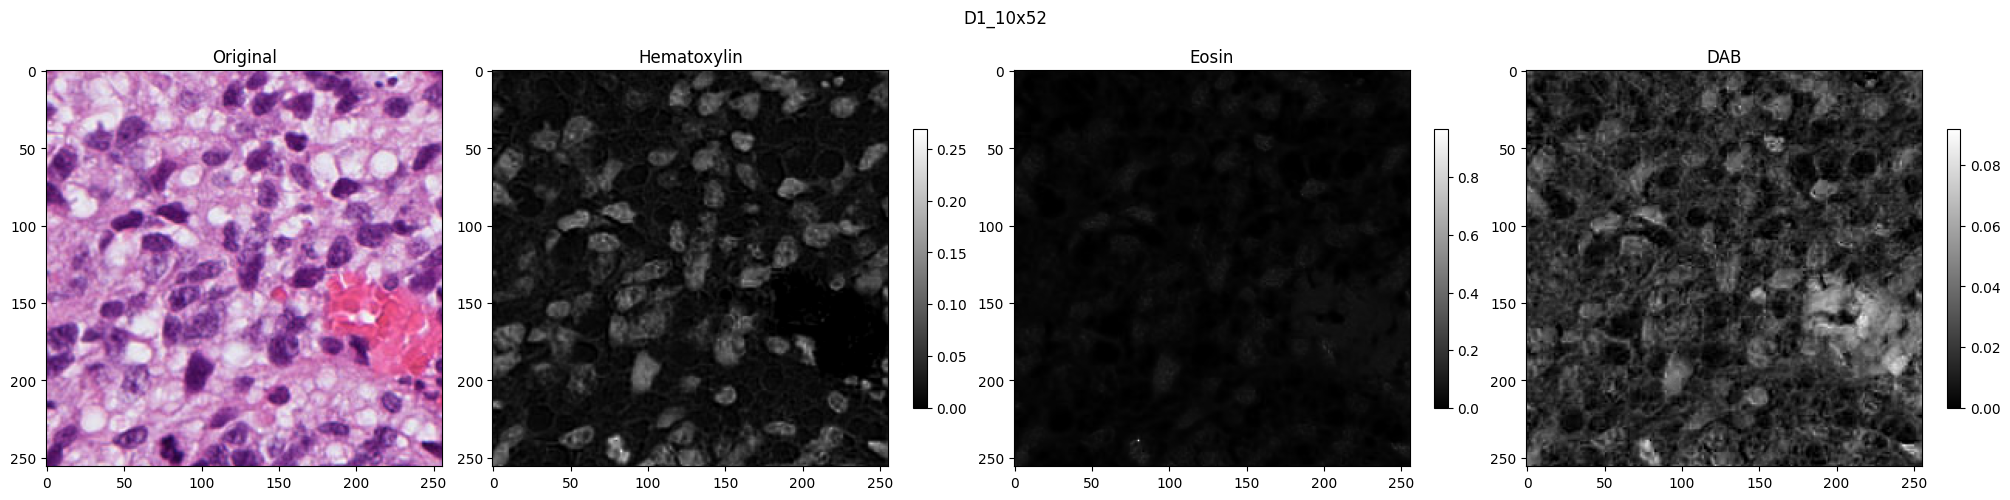

In [8]:
def load_image(image_id, image_folder=IMAGE_FOLDER):
    image_path = Path(image_folder) / f"{image_id}.png"
    im = imread(image_path)
    if im.shape[-1] == 4:
        im = rgba2rgb(im)
    return im

def show_image(image_id, image_folder=IMAGE_FOLDER, show_hed=False):
    if not show_hed:
        im = load_image(image_id, image_folder)
        plt.imshow(im)
        plt.title(image_id)
        plt.show()
    else:
        im = load_image(image_id, image_folder)
        im_hed = rgb2hed(im)
        fig, axs = plt.subplots(1, 4, figsize=(20, 5), layout="constrained")
        axs[0].imshow(im)
        axs[0].set_title("Original")
        for i, channel in enumerate(["Hematoxylin", "Eosin", "DAB"]):
            imshow = axs[i+1].imshow(im_hed[:, :, i], cmap="gray")
            axs[i+1].set_title(channel)
            fig.colorbar(imshow, ax=axs[i+1], shrink=0.6)
        fig.suptitle(image_id)
        plt.show()

np.random.seed(42)
for specimen_id in specimen_ids:
    image_ids = df[df["specimen_id"]==specimen_id].index
    show_image(image_ids[0], show_hed=True)

### iv

In [15]:
load_df = get_checkpoint("df", "with_hematoxylin")
if load_df is not None:
    df = load_df
else:
    h_channel = []
    for image_id in tqdm(df.index):
        im = load_image(image_id)
        im_hed = rgb2hed(im)
        h_channel.append(im_hed[:, :, 0].mean())
    df["Hematoxylin"] = h_channel

Loading checkpoint from checkpoints/df/with_hematoxylin.pkl


In [16]:
make_checkpoint(df, "df", "with_hematoxylin")

Checkpoint already exists.


Text(0.5, 1.0, 'H-channel mean intensity vs NESTIN expression per image')

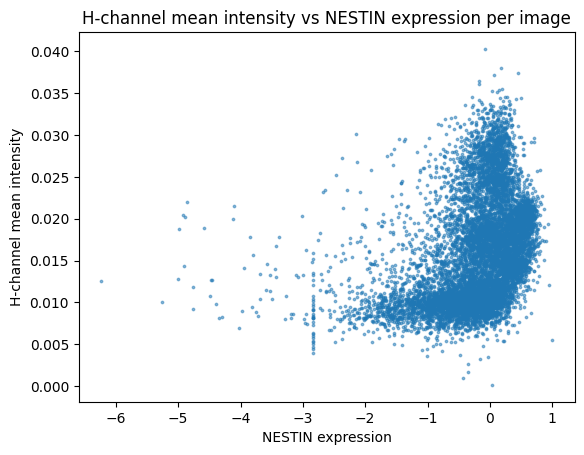

In [17]:
fig, ax = plt.subplots()
ax.scatter(df["NESTIN"], df["Hematoxylin"], alpha=0.5, s=3)
ax.set_xlabel("NESTIN expression")
ax.set_ylabel("H-channel mean intensity")
ax.set_title("H-channel mean intensity vs NESTIN expression per image")

We find the Spearman correlation coefficient for this data since it can tell us about non-linear monotonic correlation

In [18]:
df["NESTIN"].corr(df["Hematoxylin"], method="spearman")

0.45924540707372247

This tells us that there is a weak positive correlation in the data. This suggests that the average H-channel intensity could be useful but not sufficient in predicting the expression of NESTIN.

### v

Since we are trying to solve a regression problem and our target data is continuous, we should use MSE or RMSE as a performance metric. In our case, we will use RMSE.

## Question 2